In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.ndimage.filters import *
from PIL import Image

%matplotlib inline

In [2]:
################################
# STEP 1: GRAYSCALE + GAUSSIAN SMOOTHING

def image_to_gray(file_name):
    """ RETURNS GRAY CONVERSION OF IMAGE """
    return Image.open(file_name).convert('L')
lena_gray = image_to_gray('lena.bmp')

def arr_of(image):
    """ RETURNS ARRAY OF IMAGE """
    return np.asarray(image, dtype=float)
lena = arr_of(lena_gray)

def g_kernel(size, sigma):
    """ RETURNS KERNEL FOR GAUSSIAN BLURRING """
    k = size // 2
    x = np.mgrid[-k:k+1, -k:k+1][0]
    y = np.mgrid[-k:k+1, -k:k+1][1]
    H = np.exp(-(x**2.0 + y**2.0)/(2.0 * sigma**2.0)) / (2.0 * np.pi * sigma**2.0)
    return H

def GaussSmoothing(image, n, sigma):
    """ RETURNS IMAGE USING GAUSSIAN KERNEL """
    return Image.fromarray(convolve(image, g_kernel(n, sigma)))


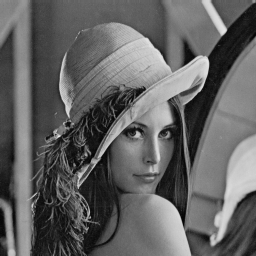

In [5]:
# IMAGE OF: LENA
lena_gray

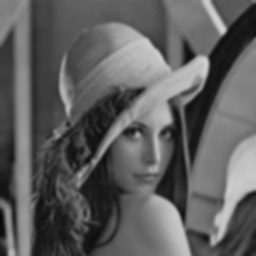

In [6]:
# IMAGE OF: GAUSSIAN BLUR
GaussSmoothing(arr_of(image_to_gray('lena.bmp')), 7, 1.5).convert('RGB')

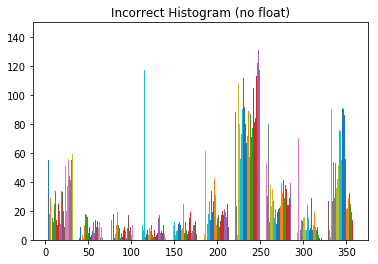

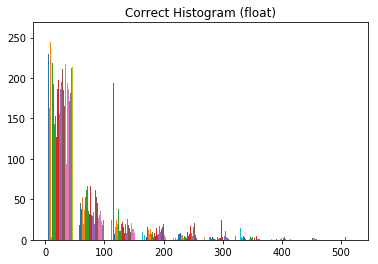

In [10]:
################################
# STEP 2: IMAGE GRADIENT

def ImageGradient(smoothed_image):
    """ RETURNS MAGNITUDE & THETA ARRAYS OF BLURRED IMAGE """
#     used the sobel filters provided in class
    sob_x = np.array([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]])
    sob_y = np.array([[ 1, 2, 1],
                      [ 0, 0, 0],
                      [-1,-2,-1]])
    x = convolve(smoothed_image, sob_x)
    y = convolve(smoothed_image, sob_y)
    mag = (x**2.0 + y**2.0)**0.5
    theta = np.arctan2(y,x)
    return mag, theta

plt.hist(np.round(ImageGradient(GaussSmoothing(lena_gray, 5, 1))[0]))
plt.title('Incorrect Histogram (no float)')
plt.show()

plt.hist(np.round(ImageGradient(GaussSmoothing(lena, 5, 1))[0]))
plt.title('Correct Histogram (float)')
plt.show()


In [11]:
################################
# STEP 3: HIGH & LOW THRESHOLDS

def FindThreshold(mag, percentage_of_non_edge):
    """ USES CUMULATIVE DISTRIBUTION FUNCTION TO CALCULATE THRESHOLDS """
    T_high = 0
    [num, bins] = np.histogram(mag)
    cum_dist = np.cumsum(num)
    cum_dist_perc = cum_dist / cum_dist[-1]
    thresh = cum_dist_perc > percentage_of_non_edge
    T_high = min(bins[np.where(thresh == True)[0]])
    T_low = T_high * 0.5
    return round(T_low, 1), round(T_high, 1)


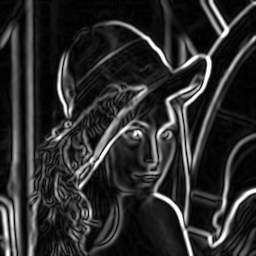

In [12]:
# IMAGE OF: GRADIENT INTENSITY
Image.fromarray(ImageGradient(GaussSmoothing(arr_of(image_to_gray('lena.bmp')), 7, 1.5))[0]).convert('RGB')

In [13]:
################################
# STEP 4: SUPRESS NONMAXIMA

def NonmaximaSupress(mag, theta):
    """ ELIMINATE POINTS THAT DON'T LIE ON IMPORTANT EDGES,
        THROUGH THE USE OF QUANTIZATION
    """
#     two possible methods: quantization / interpolation
#     I use quantization
    x,y = mag.shape
    clone = mag.copy()
    
#     convert theta (radians) to degrees
#     degree = theta * (180 / np.pi)
#     theta requires converting from angle to [0,4]
#     theta in RADIANS
    theta04 = (np.round(theta * (5.0 / np.pi)) + 5.0) % 5.0
    
    for i in range(1, x-1):
        for j in range(1, y-1):
            quant = theta04[i,j] % 4
            if i == 0 or j == 0 or i == x or j == y:
                clone[i,j] = 0
                continue
#             horizontal
            if quant == 0:
                if mag[i,j] <= mag[i,j-1]:
                    clone[i,j] = 0
                elif mag[i,j] <= mag[i,j+1]:
                    clone[i,j] = 0
#             diagonal right
            elif quant == 1:
                if mag[i,j] <= mag[i+1,j-1]:
                    clone[i,j] = 0
                elif mag[i,j] <= mag[i-1,j+1]:
                    clone[i,j] = 0
#             vertical
            elif quant == 2:
                if mag[i,j] <= mag[i-1,j]:
                    clone[i,j] = 0
                elif mag[i,j] <= mag[i+1,j]:
                    clone[i,j] = 0
#             diagonal left
            elif quant == 3:
                if mag[i,j] <= mag[i-1,j-1]:
                    clone[i,j] = 0
                elif mag[i,j] <= mag[i+1,j+1]:
                    clone[i,j] = 0
    return clone


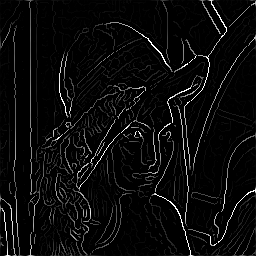

In [14]:
# IMAGE OF: NON-MAX SUPPRESION
Image.fromarray(NonmaximaSupress(ImageGradient(GaussSmoothing(arr_of(image_to_gray('lena.bmp')), 7, 1.5))[0],
                                 ImageGradient(GaussSmoothing(arr_of(image_to_gray('lena.bmp')), 7, 1.5))[1])).convert('RGB')

In [15]:
################################
# STEP 5: LINKING EDGES + TRESHOLDING

def EdgeLinking(supp, low, high):
    """ LINK STRONG EDGES WITH SLIGHTLY WEAKER ONES BASED ON
        THRESHOLD RESULTS
    """
    x,y = supp.shape
    strong_arr = np.asarray(supp > high, dtype='uint8')
    mid_arr = np.asarray(supp > low, dtype='uint8')
    strengths = strong_arr + mid_arr
    
    edges = strengths
    to_add = []
    
#     middle area
    for i in range(1, x-1):
        for j in range(1, y-1):
            if strengths[i,j] == 1:
                neighbors = strengths[i-1:i+2,j-1:j+2]
                if neighbors.max() == 2:
                    edges[i,j] = 2
                    to_add.append((i,j))
    
#     corners
    if edges[0,0] == 1:
        neighbors = edges[0:2,0:2]
        if neighbors.max() == 2:
            edges[0,0] = 2
    
    if edges[0,y-1] == 1:
        neighbors = edges[0:2,y-2:]
        if neighbors.max() == 2:
            edges[0,y-1] = 2
    
    if edges[x-1,0] == 1:
        neighbors = edges[x-2:,0:2]
        if neighbors.max() == 2:
            edges[x-1,0] = 2
    
    if edges[x-1,y-1] == 1:
        neighbors = edges[x-2:,y-2:]
        if neighbors.max() == 2:
            edges[x-1,y-1] = 2
    
#     sidelines
    for i in range(x):
        while 0 < i < x-1:
            if edges[0,i] == 1:
                neighbors = edges[0:2,i-1:i+2]
                if neighbors.max() == 2:
                    edges[0,i] = 2
            elif edges[i,0] == 1:
                neighbors = edges[i-1:i+2,0:2]
                if neighbors.max() == 2:
                    edges[i,0] = 2
            elif edges[x-1,i] == 1:
                neighbors = edges[x-2:x+1:,i-1:i+2]
                if neighbors.max() == 2:
                    edges[x-1,i] = 2
            elif edges[i,x-1] == 1:
                neighbors = edges[i-1:i+2,x-2:x+1:]
                if neighbors.max() == 2:
                    edges[i,x-1] = 2
            i += 1
    
    edges[edges == 1] = 0
    edges[edges == 2] = 255
    
    return edges

def canny(file_name, n, sigma, percent, t_low=0, t_high=0):
    """ FINAL. INPUTS:
        
        File_name,
        Gaussian Kernel Size,
        Sigma,
        Percentage of Non-Edge
    """
    img = image_to_gray(file_name)
    arr = arr_of(img)
    kern = g_kernel(n, sigma)
    smooth_img = GaussSmoothing(arr, n, sigma)
    
    mag,theta = ImageGradient(smooth_img)
    low,high = FindThreshold(mag, percent)
    if t_low != 0 or t_high != 0:
        low,high = t_low, t_high
    
    nonmax = NonmaximaSupress(mag, theta)
    final = EdgeLinking(nonmax, low, high)
    return final

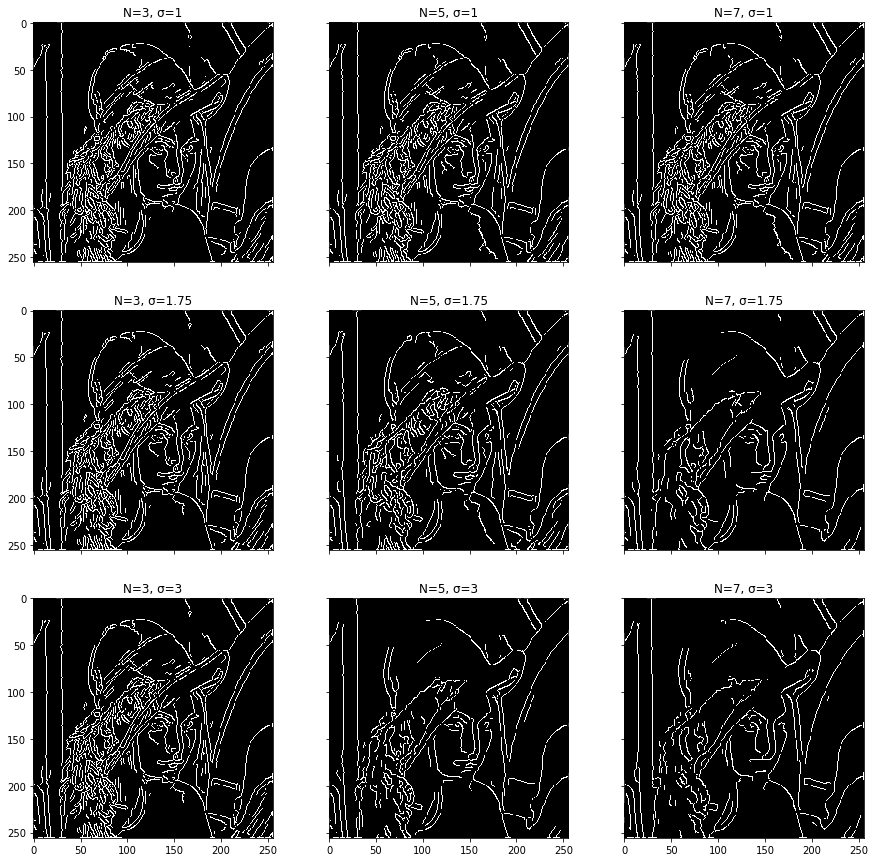

In [16]:
################################
# STEP 6: COMPARE DIFFERENT PARAMETERS

# Here I provide 6 images compared by
# their KERNEL SIZES, SIGMA values, and PERCENTAGES
################################

fig, ax = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(15, 15))

# comparing kernel across
ax[0,0].imshow(canny('lena.bmp', 3, 1, .8), cmap='Greys_r')
ax[0,0].set_title('N=3, σ=1')

ax[0,1].imshow(canny('lena.bmp', 5, 1, .8), cmap='Greys_r')
ax[0,1].set_title('N=5, σ=1')

ax[0,2].imshow(canny('lena.bmp', 7, 1, .8), cmap='Greys_r')
ax[0,2].set_title('N=7, σ=1')

# comparing sigma to above
ax[1,0].imshow(canny('lena.bmp', 3, 1.75, .8), cmap='Greys_r')
ax[1,0].set_title('N=3, σ=1.75')

ax[1,1].imshow(canny('lena.bmp', 5, 1.75, .8), cmap='Greys_r')
ax[1,1].set_title('N=5, σ=1.75')

ax[1,2].imshow(canny('lena.bmp', 7, 1.75, .8), cmap='Greys_r')
ax[1,2].set_title('N=7, σ=1.75')

ax[2,0].imshow(canny('lena.bmp', 3, 3, .8), cmap='Greys_r')
ax[2,0].set_title('N=3, σ=3')

ax[2,1].imshow(canny('lena.bmp', 5, 3, .8), cmap='Greys_r')
ax[2,1].set_title('N=5, σ=3')

ax[2,2].imshow(canny('lena.bmp', 7, 3, .8), cmap='Greys_r')
ax[2,2].set_title('N=7, σ=3')

plt.show()


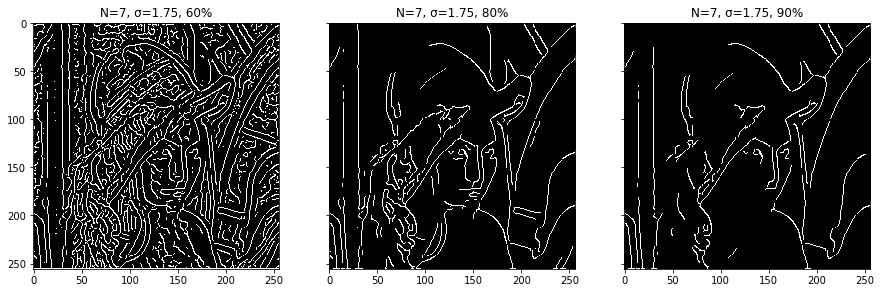

In [17]:
# comparing percentage across
fig, ax = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(15, 15))

ax[0].imshow(canny('lena.bmp', 7, 1.75, .6), cmap='Greys_r')
ax[0].set_title('N=7, σ=1.75, 60%')

ax[1].imshow(canny('lena.bmp', 7, 1.75, .8), cmap='Greys_r')
ax[1].set_title('N=7, σ=1.75, 80%')

ax[2].imshow(canny('lena.bmp', 7, 1.75, .9), cmap='Greys_r')
ax[2].set_title('N=7, σ=1.75, 90%')

plt.show()


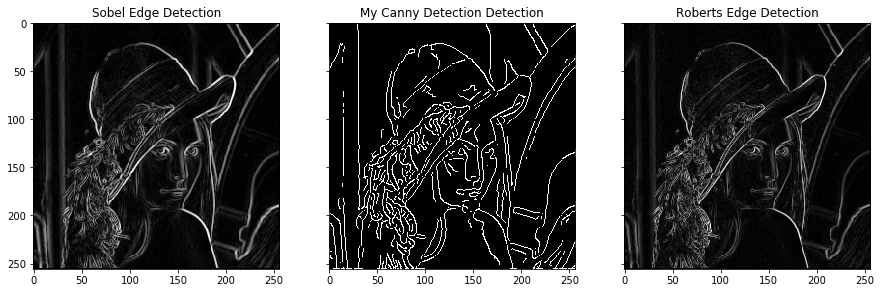

In [18]:
################################
# STEP 7: COMPARE DIFFERENT EDGE DETECTORS

# For this step I imported a sobel and roberts
# edge detector package only to be used for comparison!

from skimage.filters import roberts, sobel
################################

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 15))
ax[0].imshow(sobel(image_to_gray('lena.bmp')), cmap='Greys_r')
ax[0].set_title('Sobel Edge Detection')
ax[1].imshow(canny('lena.bmp', 9, 1.5, .8), cmap='Greys_r')
ax[1].set_title('My Canny Detection Detection')
ax[2].imshow(roberts(image_to_gray('lena.bmp')), cmap='Greys_r')
ax[2].set_title('Roberts Edge Detection')
plt.show()


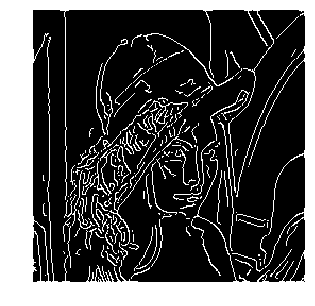

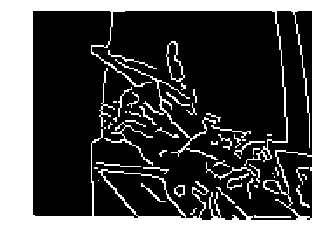

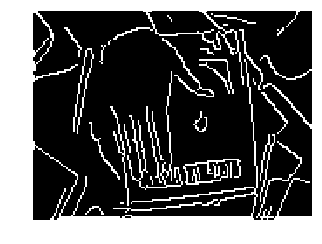

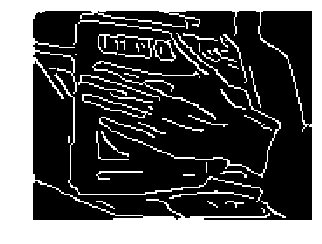

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


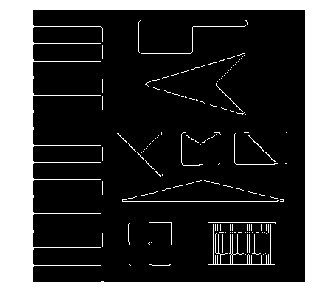

In [19]:
# CHECKING ALL TEST CASES

# lena
fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(canny('lena.bmp', 5, 1.75, .8), cmap='Greys_r')
# plt.title('LENA')
plt.axis('off')
plt.show()

# gun
fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(canny('gun1.bmp', 5, 1, .8), cmap='Greys_r')
# plt.title('GUN')
plt.axis('off')
plt.show()

# joy
fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(canny('joy1.bmp', 3, 1.2, .8), cmap='Greys_r')
# plt.title('JOY')
plt.axis('off')
plt.show()

# pointer
fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(canny('pointer1.bmp', 5, 1.5, .8), cmap='Greys_r')
# plt.title('POINTER')
plt.axis('off')
plt.show()

# test
fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(canny('test1.bmp', 3, 1.5, .3), cmap='Greys_r')
# plt.title('TEST')
plt.axis('off')
plt.show()
